<div style="text-align:right;">Justine Charrel - Master 1 Internship</div>

This script calculate the differences between the radiosoundings of ERA5 and them of MOSAiC. It plots their distribution and profiles.

### IMPORT

In [1]:
from netCDF4 import Dataset as ncfile
import numpy as np
from netCDF4 import num2date
import matplotlib.dates as dates
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import cmath
import numpy.ma as ma

### READ DATA

In [2]:
ppidir = '/lustre/storeB/users/justinec/master_internship/data/ERA5_MOSAiC/'
data_link  = ppidir + 'concatenated_ERA5_MOSAiC.nc'

data = ncfile(data_link,'r')    #dataset of radiosoundings of MOSAiC and ERA5

In [3]:
pres = data.variables['pres'][:]
lat = data.variables['lat_mosaic'][:] 
lon = data.variables['lon_mosaic'][:]
time = data.variables['time_mosaic'][:]
era5_temp = data.variables['temp_era5'][:]
era5_rh = data.variables['rh_era5'][:]
era5_sh = data.variables['sh_era5'][:]
era5_wdir = data.variables['wdir_era5'][:]
era5_wspeed = data.variables['wspeed_era5'][:]
mosaic_temp = data.variables['temp_mosaic'][:]
mosaic_rh = data.variables['rh_mosaic'][:]
mosaic_sh = data.variables['sh_mosaic'][:]
mosaic_wdir = data.variables['wdir_mosaic'][:]
mosaic_wspeed = data.variables['wspeed_mosaic'][:]

### REPLACE MASKED/NAN VALUES BY INTERPOLATION BETWEEN NEAREST VALUES

In [4]:
mosaic_rh = np.ma.masked_object(mosaic_rh, mosaic_rh[559][11]) # mask outlier value

In [5]:
def replacenan(var) :
    new_var = np.zeros((len(var),len(pres)))
    for i in range(0,len(var)) :
        for j in range(0,len(var[i])) :
            if ma.getmask(var)[i][j] == True :
                #print('masked value in {}, {}'.format(i,j))
                if j == 28 :
                    #print('value in j-1 : {}, value in j-2 : {}'.format(var[i][j-1],var[i][j-2]))
                    new_var[i][j] = var[i][j-1]+(var[i][j-1]-var[i][j-2])
                    #print('new value :', new_var[i][j])
                else :
                    #print(var[i][j-1],var[i][j+1])
                    new_var[i][j] = np.mean([var[i][j-1],var[i][j+1]])
                    #print(new_var[i][j])
            else :
                new_var[i][j] = var[i][j]  
    return new_var

In [6]:
new_mosaic_temp = replacenan(mosaic_temp)
new_mosaic_rh = replacenan(mosaic_rh)
new_mosaic_wdir = replacenan(mosaic_wdir)
new_mosaic_wspeed = replacenan(mosaic_wspeed)

#Verify there is no more masked/nan values
print('temp nan values :', ma.count_masked(new_mosaic_temp))
print('rh nan values :', ma.count_masked(new_mosaic_rh))
print('wdir nan values :', ma.count_masked(new_mosaic_wdir))
print('wspeed nan values :', ma.count_masked(new_mosaic_wspeed))

temp nan values : 0
rh nan values : 0
wdir nan values : 0
wspeed nan values : 0


### CALCULATE THE BIASES BETWEEN ERA5 AND MOSAiC

In [7]:
temp_bias = era5_temp-new_mosaic_temp
rh_bias = era5_rh-new_mosaic_rh
sh_bias = era5_sh-mosaic_sh
wspeed_bias = era5_wspeed-new_mosaic_wspeed

In [8]:
# need to use direction errors
wdir_bias = era5_wdir-new_mosaic_wdir
for i in range(len(wdir_bias)) :
    for n in range(len(wdir_bias[i])) :
        if wdir_bias[i][n] > 180 :
            wdir_bias[i][n] = wdir_bias[i][n]-360
        if wdir_bias[i][n] < -180 :
            wdir_bias[i][n] = wdir_bias[i][n]+360

### DISTRIBUTION OF THE BIASES

In [9]:
def varlevel(var) :
    var_1000 = []
    var_900 = []
    var_600 = []
    var_300 = []
    for i in range(len(var)) :
        var_1000.append(var[i][28])
        var_900.append(var[i][25])
        var_600.append(var[i][12])
        var_300.append(var[i][0])
    return(var_1000,var_900,var_600,var_300)

In [10]:
temp_bias_1000, temp_bias_900, temp_bias_600, temp_bias_300 = varlevel(temp_bias)
rh_bias_1000, rh_bias_900, rh_bias_600, rh_bias_300 = varlevel(rh_bias)
sh_bias_1000, sh_bias_900, sh_bias_600, sh_bias_300 = varlevel(sh_bias)
wdir_bias_1000, wdir_bias_900, wdir_bias_600, wdir_bias_300 = varlevel(wdir_bias)
wspeed_bias_1000, wspeed_bias_900, wspeed_bias_600, wspeed_bias_300 = varlevel(wspeed_bias)

In [11]:
np.max(rh_bias_1000)

56.856329788753555

In [12]:
def plotdistribution() :
    parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':16, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                      'legend.title_fontsize':20, 'figure.titlesize':25}
    plt.rcParams.update(parameters)
    fig = plt.figure(figsize=(30,15))
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
    ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
    ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
    ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
    ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
    sns.histplot(temp_bias_300, binrange=(-10,10), binwidth=0.1, label='300 hPa', ax=ax1, alpha=0.4, color='purple')
    sns.histplot(temp_bias_600, binrange=(-10,10), binwidth=0.1, label='600 hPa', ax=ax1, alpha=0.4, color='yellow')
    sns.histplot(temp_bias_900, binrange=(-10,10), binwidth=0.1, label='900 hPa', ax=ax1, alpha=0.4, color='green')
    sns.histplot(temp_bias_1000, binrange=(-10,10), binwidth=0.1, label='1000 hPa', ax=ax1, alpha=0.4, color='red')
    ax1.set(ylabel='Number of occurences', xlabel='T difference [K]')
    #axs[0,0].set_xlim(-10,10)
    ax1.legend()

    sns.histplot(rh_bias_300, binrange=(-50,100), binwidth=1, label='300 hPa', ax=ax2, alpha=0.4, color='purple')
    sns.histplot(rh_bias_600, binrange=(-50,100), binwidth=1, label='600 hPa', ax=ax2, alpha=0.4, color='yellow')
    sns.histplot(rh_bias_900, binrange=(-50,100), binwidth=1, label='900 hPa', ax=ax2, alpha=0.4, color='green')
    sns.histplot(rh_bias_1000, binrange=(-50,100), binwidth=1, label='1000 hPa',ax=ax2, alpha=0.4, color='red')
    ax2.set(ylabel='', xlabel='RH difference [%]')
    ax2.legend()
    
    sns.histplot(sh_bias_300, binrange=(-1,1), binwidth=0.02, label='300 hPa', ax=ax3, alpha=0.4, color='purple')
    sns.histplot(sh_bias_600, binrange=(-1,1), binwidth=0.02, label='600 hPa', ax=ax3, alpha=0.4, color='yellow')
    sns.histplot(sh_bias_900, binrange=(-1,1), binwidth=0.02, label='900 hPa', ax=ax3, alpha=0.4, color='green')
    sns.histplot(sh_bias_1000, binrange=(-1,1), binwidth=0.02, label='1000 hPa',ax=ax3, alpha=0.4, color='red')
    ax3.set(ylabel='', xlabel='SH difference [$g.kg^{-1}$]')
    ax3.legend()

    sns.histplot(wdir_bias_300, binrange=(-150,150), binwidth=2, label='300 hPa', ax=ax4, alpha=0.4, color='purple')
    sns.histplot(wdir_bias_600, binrange=(-150,150), binwidth=2, label='600 hPa', ax=ax4, alpha=0.4, color='yellow')
    sns.histplot(wdir_bias_900, binrange=(-150,150), binwidth=2, label='900 hPa', ax=ax4, alpha=0.4, color='green')
    sns.histplot(wdir_bias_1000, binrange=(-150,150), binwidth=2, label='1000 hPa', ax=ax4, alpha=0.4, color='red')
    ax4.set(ylabel='Number of occurences', xlabel='Wind direction difference [degree]')
    ax4.legend()

    sns.histplot(wspeed_bias_300, binrange=(-15,15), binwidth=0.2, label='300 hPa', ax=ax5, alpha=0.4, color='purple')
    sns.histplot(wspeed_bias_600, binrange=(-15,15), binwidth=0.2, label='600 hPa', ax=ax5, alpha=0.4, color='yellow')
    sns.histplot(wspeed_bias_900, binrange=(-15,15), binwidth=0.2, label='900 hPa', ax=ax5, alpha=0.4, color='green')
    sns.histplot(wspeed_bias_1000, binrange=(-15,15), binwidth=0.2, label='1000 hPa', ax=ax5, alpha=0.4, color='red')
    ax5.set(ylabel='', xlabel=r'Wind speed difference [$m.s^{-1}$]')
    ax5.legend()

    fig.suptitle('Distribution of differences betweeen ERA5 and MOSAiC')
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)
    path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
    plt.savefig(path_fig+'fig_biases_distribution.png')

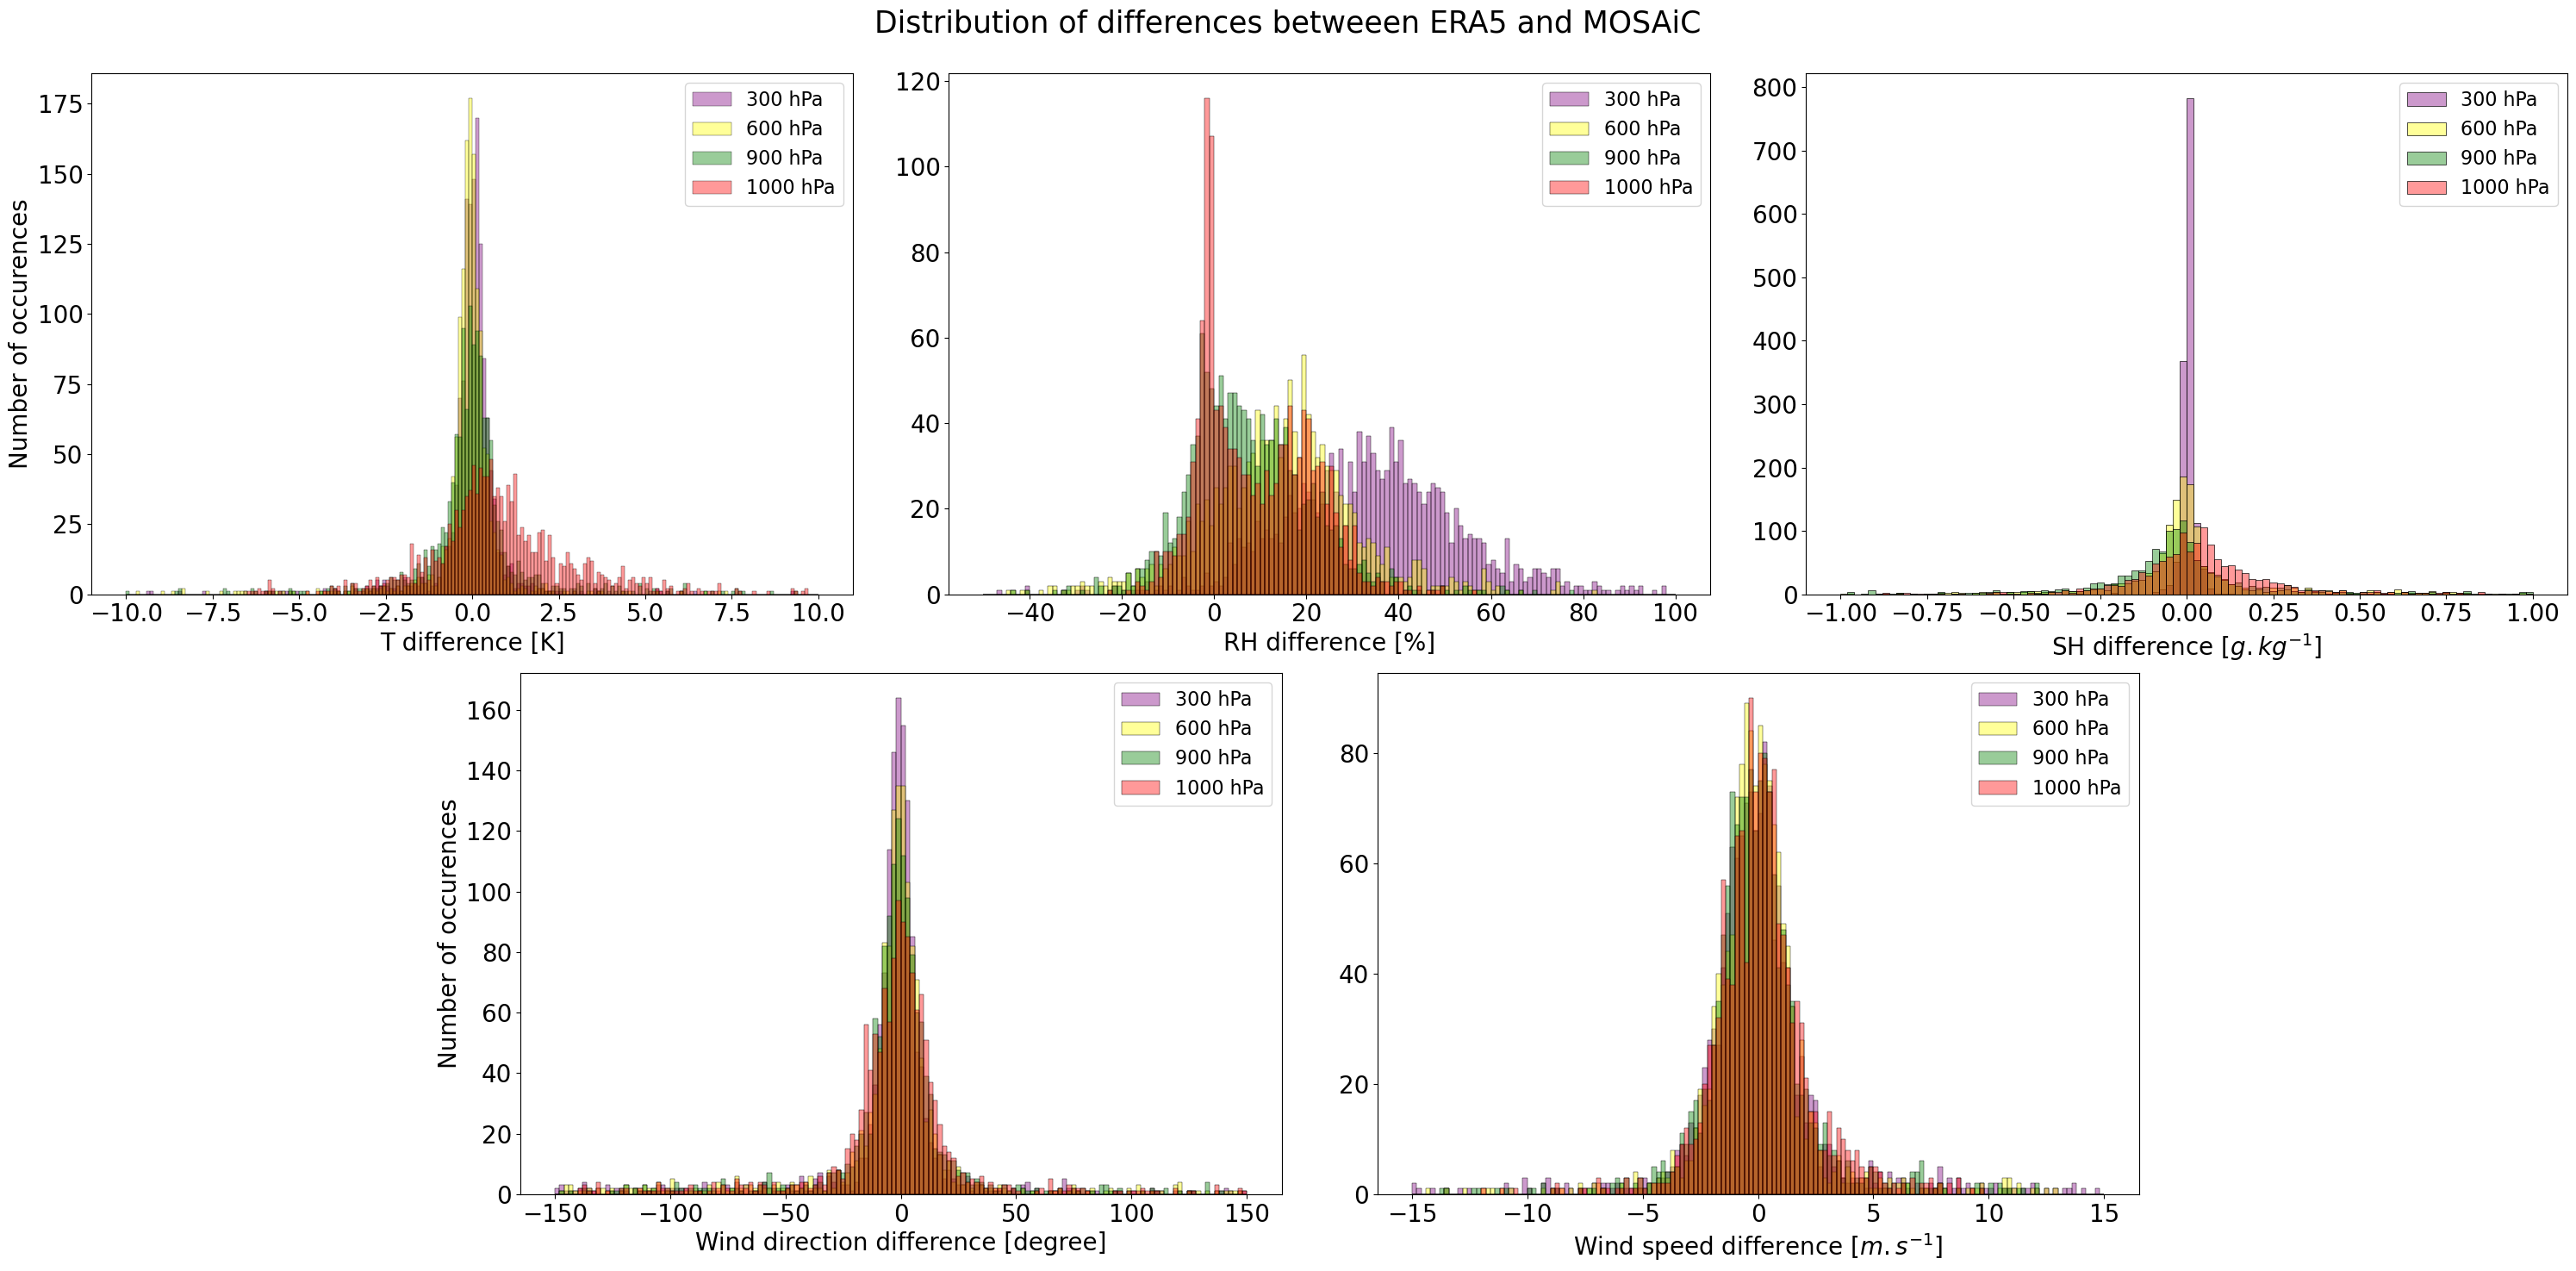

In [13]:
plotdistribution()

### CALCULATE MEAN, STANDARD DEVIATION AND CORRELATION COEFFICIENT OF EVERY PRESSURE LEVEL FOR ALL RADIOSONDES

In [14]:
def meanstd(var) :
    mean = np.mean(var, axis=0)
    std  = np.std(var, axis=0)
    return(mean,std)

In [15]:
mean_temp_bias, std_temp_bias = meanstd(temp_bias)
mean_rh_bias, std_rh_bias = meanstd(rh_bias)
mean_sh_bias, std_sh_bias = meanstd(sh_bias)
mean_wdir_bias, std_wdir_bias = meanstd(wdir_bias)
mean_wspeed_bias, std_wspeed_bias = meanstd(wspeed_bias)

In [16]:
def corr_coef(mosaic,era5) :
    mosaic_level = [] ; era5_level = [] ; r=[]
    for n in range(len(mosaic[0])) :
        for i in range(len(mosaic)) :
            mosaic_level.append(mosaic[i][n])
            era5_level.append(era5[i][n])
        r.append(np.corrcoef(mosaic_level, era5_level)[0,1])
    return r

In [29]:
len(new_mosaic_temp)

1399

In [ ]:
mosaic_level = [] ; era5_level = [] ; r=[]
for n in range(0,1) :
    for i in range(len(new_mosaic_temp)) :
        mosaic_level.append(new_mosaic_temp[i][n])
        print('mosaic', new_mosaic_temp[i][n])
        era5_level.append(era5_temp[i][n])
        print('era5', era5_temp[i][n])
    r.append(np.corrcoef(mosaic_level, era5_level)[0,1])

In [35]:
r

[0.9404020418695938]

In [26]:
np.corrcoef(new_mosaic_temp[0][0],era5_temp[0][0])

/lustre/storeB/users/justinec/myconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/lustre/storeB/users/justinec/myconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/lustre/storeB/users/justinec/myconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


array([[nan, nan],
       [nan, nan]])

In [17]:
r_temp = corr_coef(new_mosaic_temp,era5_temp)
r_rh = corr_coef(new_mosaic_rh,era5_rh)
r_sh = corr_coef(mosaic_sh,era5_sh)
r_wspeed = corr_coef(new_mosaic_wspeed,era5_wspeed)

In [18]:
'''This function calculate the differences between IFS and MOSAiC for a circular variable, the wind direction'''
def circular_correlation_coefficient(variable1, variable2):
        #
        var1_rad = variable1 * np.pi / 180
        var2_rad = variable2 * np.pi / 180
        #
        var1_com = np.full(np.shape(variable1), np.nan, dtype = complex)
        var2_com = np.full(np.shape(variable2), np.nan, dtype = complex)
        for i in range(0, len(variable1)):
                var1_com[i] = cmath.rect(1, var1_rad[i])
                var2_com[i] = cmath.rect(1, var2_rad[i])
        #
        var1_com_mean = np.mean(var1_com)
        var2_com_mean = np.mean(var2_com)
        #
        var1_rad_mean = cmath.phase(var1_com_mean)
        if var1_rad_mean < 0:
                var1_rad_mean = var1_rad_mean + 2 * np.pi
        #
        var2_rad_mean = cmath.phase(var2_com_mean)
        if var2_rad_mean < 0:
                var2_rad_mean = var2_rad_mean + 2 * np.pi
        #
        diff_var1 = var1_rad - var1_rad_mean
        diff_var2 = var2_rad - var2_rad_mean
        #
        Rcc = np.sum(np.sin(diff_var1) * np.sin(diff_var2)) / np.sqrt(np.sum(np.sin(diff_var1) ** 2) * np.sum(np.sin(diff_var2) ** 2))
        #
        return Rcc

In [19]:
mosaic_level = [] ; era5_level = [] ; r_wdir=[]
for n in range(len(pres)):
    for i in range(len(new_mosaic_wdir)) :
        mosaic_level.append(new_mosaic_wdir[i][n])
        era5_level.append(era5_wdir[i][n])
    mosaic_level_array = np.array(mosaic_level)
    era5_level_array = np.array(era5_level)
    r_wdir.append(circular_correlation_coefficient(mosaic_level_array, era5_level_array))

### PLOT PROFILES OF THE BIASES

In [21]:
def plotbiases() :
    
    import matplotlib.gridspec as gridspec

    parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':16, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                  'legend.title_fontsize':20, 'figure.titlesize':25}
    plt.rcParams.update(parameters)

    fig, axs = plt.subplots(1,5,figsize=(30,15))
    for i in range(len(temp_bias)) :
        axs[0].plot(temp_bias[i], pres, 'gray', alpha=0.3)
    axs[0].fill_betweenx(pres, mean_temp_bias-std_temp_bias, mean_temp_bias+std_temp_bias, label='standard deviation', alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[0].plot(mean_temp_bias, pres, 'k', label = 'mean')
    axs0 = axs[0].twiny()
    axs0.plot(r_temp, pres, 'r', label = 'correlation coefficient')
    axs0.set_xlim(0.65,1)
    axs0.set_xlabel('r', color='r')
    axs0.spines['top'].set_color('red')
    axs0.tick_params(axis='x', colors='red')
    axs[0].invert_yaxis()
    axs[0].set_xlabel ('T [K]')
    axs[0].set_ylabel ('Pressure [hPa]')
    
    for i in range(len(rh_bias)) :
        axs[1].plot(rh_bias[i], pres, 'gray', alpha=0.3)
    axs[1].fill_betweenx(pres, mean_rh_bias-std_rh_bias, mean_rh_bias+std_rh_bias, alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[1].plot(mean_rh_bias, pres, 'k')
    axs1 = axs[1].twiny()
    axs1.plot(r_rh, pres, 'r')
    axs1.set_xlim(0.65,1)
    axs1.set_xlabel('r', color='r')
    axs1.spines['top'].set_color('red')
    axs1.tick_params(axis='x', colors='red')
    axs[1].invert_yaxis()
    axs[1].set_xlabel ('RH [%]')
    
    for i in range(len(sh_bias)) :
        axs[2].plot(sh_bias[i], pres, 'gray', alpha=0.3)
    axs[2].fill_betweenx(pres, mean_sh_bias-std_sh_bias, mean_sh_bias+std_sh_bias, alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[2].plot(mean_sh_bias, pres, 'k')
    axs2 = axs[2].twiny()
    axs2.plot(r_sh, pres, 'r')
    axs2.set_xlim(0,1)
    axs2.set_xlabel('r', color='r')
    axs2.spines['top'].set_color('red')
    axs2.tick_params(axis='x', colors='red')
    axs[2].invert_yaxis()
    axs[2].set_xlabel ('SH [$g.kg^{-1}$]')

    for i in range(len(wdir_bias)) :
        axs[3].plot(wdir_bias[i], pres, 'gray', alpha=0.3)
    axs[3].fill_betweenx(pres, mean_wdir_bias-std_wdir_bias, mean_wdir_bias+std_wdir_bias, alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[3].plot(mean_wdir_bias, pres, 'k')
    axs3 = axs[3].twiny()
    axs3.plot(r_wdir, pres, 'r')
    axs3.set_xlim(0,1)
    axs3.set_xlabel('r', color='r')
    axs3.spines['top'].set_color('red')
    axs3.tick_params(axis='x', colors='red')
    axs[3].invert_yaxis()
    axs[3].set_xlabel ('Wind direction [degree]')

    for i in range(len(wspeed_bias)) :
        axs[4].plot(wspeed_bias[i], pres, 'gray', alpha=0.3)
    axs[4].fill_betweenx(pres, mean_wspeed_bias-std_wspeed_bias, mean_wspeed_bias+std_wspeed_bias, alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[4].plot(mean_wspeed_bias, pres, 'k')
    axs4 = axs[4].twiny()
    axs4.plot(r_wspeed, pres, 'r')
    axs4.set_xlim(0.65,1)
    axs4.set_xlabel('r', color='r')
    axs4.spines['top'].set_color('red')
    axs4.tick_params(axis='x', colors='red')
    axs[4].invert_yaxis()
    axs[4].set_xlabel (r'Wind speed [$m.s^{-1}$]')

    #date = day + '/' + month + '/' + year + ' ' + hour + ':' + date_task[10:12] + ':' + date_task[12:14]
    #fig.suptitle(date, size=16)
    fig.suptitle('Difference between ERA5 and MOSAiC from 10/2019 to 10/2020')
    fig.legend()
    fig.tight_layout()
    fig.subplots_adjust(top=0.87)
    path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
    #plt.savefig(path_fig+'fig_biases_'+date_task+'.png')
    plt.savefig(path_fig+'fig_biases.png')

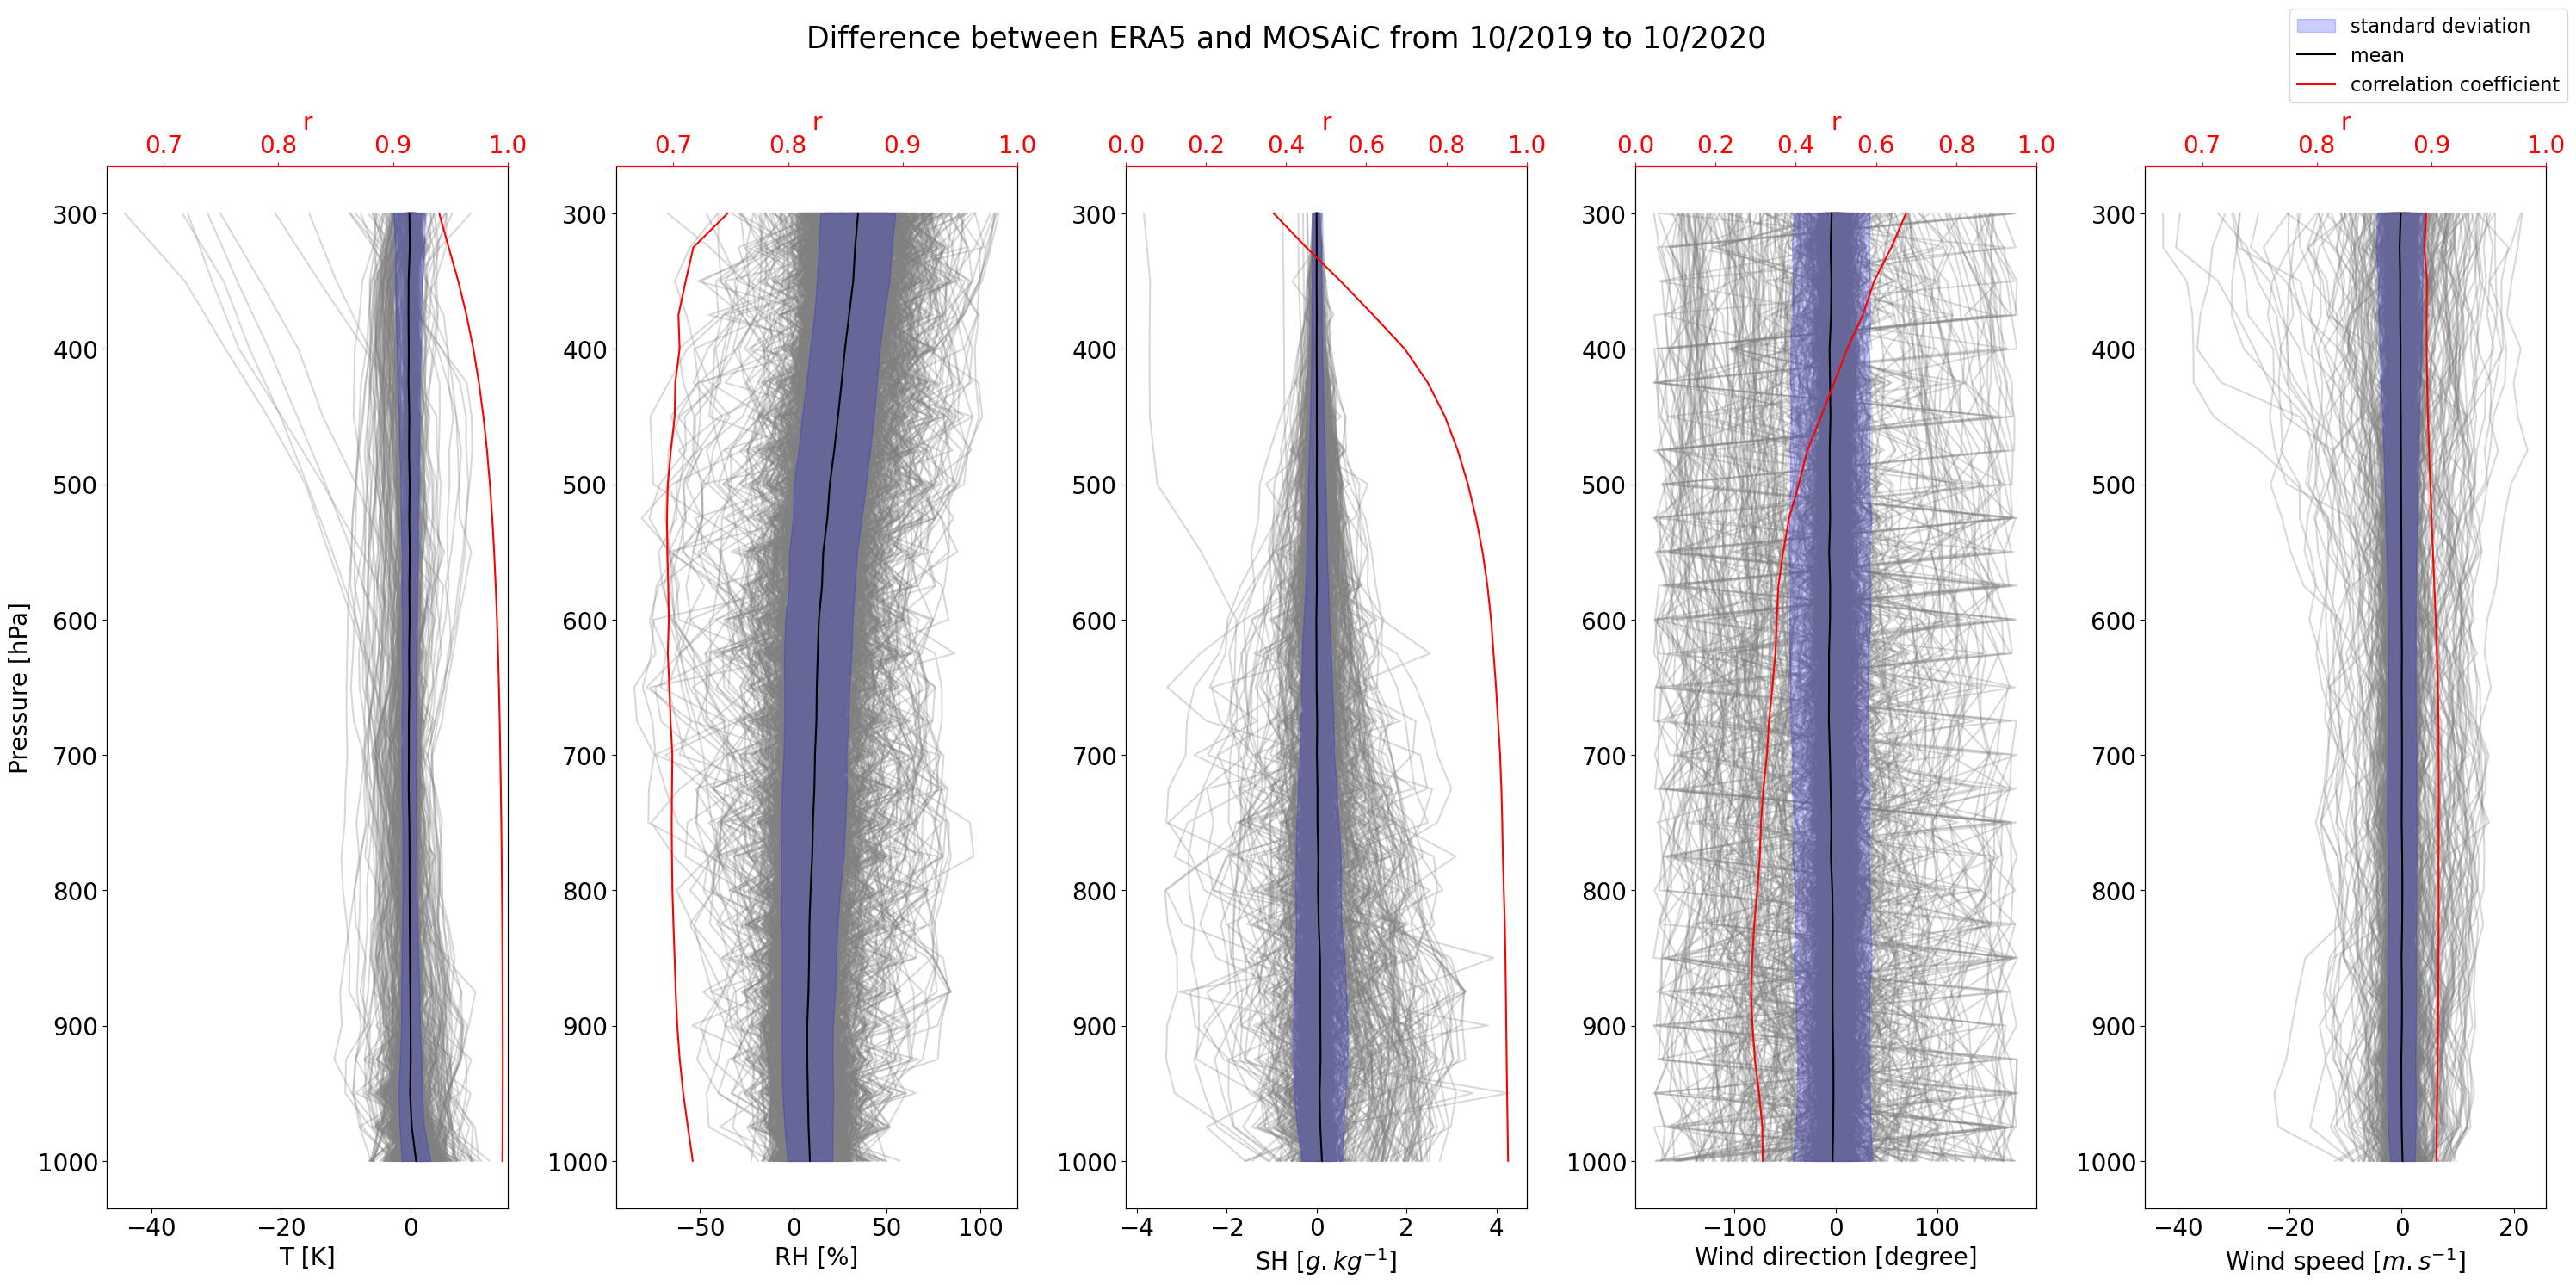

In [22]:
plotbiases() #comment this line to not plot figures
#positive = surestimation in ERA5